In [4]:
!pip install tensorflow_addons
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 17.8 MB/s eta 0:00:00


In [5]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_addons as tfa
from transformers import AutoTokenizer,TFRobertaModel

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.80.151.146:8470


REPLICAS:  8


# Data Prep


In [7]:
train_dir = "/content/drive/Shareddrives/TechnoRegulation/Progetto/splitting/Train.csv"

df = pd.read_csv(train_dir)
df2 = pd.read_csv('/content/drive/Shareddrives/TechnoRegulation/Progetto/splitting/Val.csv')
df = pd.concat([df,df2],axis= 0, ignore_index= True)
x = (df['Text']
     .str.lower()     
     .str.replace('\x89Ûª|Ûª', "'")
     .str.replace('\n|\x89.|\x9d *', ' ')
     .str.replace('&gt;', ">")
     .str.replace('&lt;', "<")
     .str.replace('&amp;', " and ")
     .str.replace('won\'t', 'will not')
     .str.replace('can\'t', 'cannot')
     .str.replace('i\'m', 'i am')
     .str.replace('ain\'t', 'is not')
     .str.replace('hwy.', 'highway')
     .str.replace('(\w+)\'ll', '\g<1> will')
     .str.replace('(\w+)n\'t', '\g<1> not')
     .str.replace('(\w+)\'ve', '\g<1> have')
     .str.replace('(\w+)\'s', '\g<1> is')
     .str.replace('(\w+)\'re', '\g<1> are')
     .str.replace('(\w+)\'d', '\g<1> would')     
     .str.replace('(\w+)\'m', '\g<1> am')
     .str.replace('<3', 'love')
     .str.replace('w/e', 'whatever')
     .str.replace('w/', 'with')    
     .str.replace('\b', ' ')
     .str.replace('-', ' ')
     .str.replace('  *', ' ')
     .str.strip()
     .to_numpy()
    )
y = df['class_label'].to_numpy()

x_train, x_val, y_train, y_val = train_test_split(x, y, train_size = 0.7, random_state = 1000)

In [8]:
x[0:20]

array(['kat and andre make me sick they dont deserve to be there mkr',
       'its melting because you didnt put it in the freezer before you served it you dumb skank mkr',
       'rt dedicated to all those women who marched to celebrate international womens day without denouncing islam ht',
       'rt not sexist but ill never vote for a woman president because i dont think any woman is mentally stable enough maybe',
       'to skier dude i am so mad at you for deleting the page for barry dejay you may think your really cool but your a head i finally could of found an awesome cheat for my sons game but for stupidity ruined it hope you feel like crap that was a funny reliable sourced well argued article but your ness had to ruin it get a life and stop wikipedia on your computer all day',
       'shut up michelle you and your communist husband are nothing but parasidic scum go back to the garbage can you came from and leave the united states of america alone you are both impostures steal

# Tokenizer

BertTweet : https://huggingface.co/docs/transformers/model_doc/bertweet

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('vinai/bertweet-base', 
                                          normalization=True, 
                                          use_fast = False,
                                          add_special_tokens=True,
                                          pad_to_max_length=True,
                                          return_attention_mask=True)

train_token = tokenizer(x_train.tolist(), 
                    padding="max_length", 
                    truncation=True,
                    return_tensors = 'tf').data
val_token = tokenizer(x_val.tolist(), 
                    padding="max_length", 
                    truncation=True,
                    return_tensors = 'tf').data

train_features = {x: train_token[x] for x in tokenizer.model_input_names}
train_tf_dataset = tf.data.Dataset.from_tensor_slices((train_features, y_train))
train_tf_dataset = train_tf_dataset.shuffle(len(x_train)).batch(32).prefetch(tf.data.AUTOTUNE)

val_features = {x: val_token[x] for x in tokenizer.model_input_names}
val_tf_dataset = tf.data.Dataset.from_tensor_slices((val_features, y_val))
val_tf_dataset = val_tf_dataset.shuffle(len(x_val)).batch(32).prefetch(tf.data.AUTOTUNE)

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# Train



In [10]:
with strategy.scope():  
    bert_model = TFRobertaModel.from_pretrained("vinai/bertweet-base")

def build_model(hidden_n, drop = 0.3, lr = 1e-5, weight_decay = 1e-6):
    with strategy.scope():    
        input_ids = tf.keras.Input(shape=(128,),dtype='int32', name = 'input_ids')
        attention_masks = tf.keras.Input(shape=(128,),dtype='int32', name = 'attention_mask')

        output = bert_model([input_ids,attention_masks])[1]
        output = tf.keras.layers.Dense(hidden_n,activation='relu')(output)
        output = tf.keras.layers.Dropout(drop)(output)
        output = tf.keras.layers.Dense(1,activation='sigmoid')(output)

        model = tf.keras.models.Model(inputs = [input_ids,attention_masks], outputs = output)

        f1_score = tfa.metrics.F1Score(1, threshold = 0.5)
        model.compile(tfa.optimizers.AdamW(weight_decay = weight_decay, lr=lr), 
                      loss='binary_crossentropy', 
                      metrics=['accuracy', f1_score])

        # Prevent training the transformer from training again
        model.layers[2].trainable = False
        
        return model

Some layers from the model checkpoint at vinai/bertweet-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/bertweet-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [11]:
grid = [{'hidden_n': 16, 'drop': 0.3, 'lr': 1e-5, 'weight_decay': 1e-6},
        {'hidden_n': 32, 'drop': 0.3, 'lr': 1e-5, 'weight_decay': 1e-6},
        {'hidden_n': 32, 'drop': 0.3, 'lr': 5e-6, 'weight_decay': 1e-6},
        {'hidden_n': 32, 'drop': 0.25, 'lr': 1e-5, 'weight_decay': 5e-6},
        {'hidden_n': 32, 'drop': 0.35, 'lr': 1e-5, 'weight_decay': 5e-7},
        {'hidden_n': 64, 'drop': 0.3, 'lr': 1e-5, 'weight_decay': 1e-6},
        {'hidden_n': 64, 'drop': 0.3, 'lr': 1e-5, 'weight_decay': 5e-6},
       ]

def run_loop(**kwargs):
    model = build_model(**kwargs)
    history = model.fit(train_tf_dataset,
                        validation_data = val_tf_dataset,
                        epochs = 2)
    #save model
    model.save(f'/content/drive/Shareddrives/TechnoRegulation/Progetto/bert_tweet/models/model{kwargs["hidden_n"]}_{kwargs["drop"]}_{kwargs["lr"]}_{kwargs["weight_decay"]}.h5')
    return {**kwargs, 'model': model, 'f1': history.history['val_f1_score'][-1][0]}
results = [run_loop(**params) for params in grid]

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/2


/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:638: UserWarning: Input dict contained keys ['token_type_ids'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


1471/1471 [==============================] - 342s 146ms/step - loss: 0.2389 - accuracy: 0.9110 - f1_score: 0.8928 - val_loss: 0.1772 - val_accuracy: 0.9313 - val_f1_score: 0.9192
Epoch 2/2
1471/1471 [==============================] - 154s 105ms/step - loss: 0.1585 - accuracy: 0.9444 - f1_score: 0.9336 - val_loss: 0.1742 - val_accuracy: 0.9338 - val_f1_score: 0.9219
Epoch 1/2
1471/1471 [==============================] - 138s 63ms/step - loss: 0.2665 - accuracy: 0.9291 - f1_score: 0.9187 - val_loss: 0.1836 - val_accuracy: 0.9334 - val_f1_score: 0.9215
Epoch 2/2
1471/1471 [==============================] - 69s 47ms/step - loss: 0.1263 - accuracy: 0.9591 - f1_score: 0.9511 - val_loss: 0.1843 - val_accuracy: 0.9339 - val_f1_score: 0.9217
Epoch 1/2
1471/1471 [==============================] - 135s 63ms/step - loss: 0.2989 - accuracy: 0.9490 - f1_score: 0.9403 - val_loss: 0.1980 - val_accuracy: 0.9329 - val_f1_score: 0.9215
Epoch 2/2
1471/1471 [==============================] - 69s 47ms/step 

In [20]:
results = pd.DataFrame(results).sort_values('f1', ascending=False)
model = results.model[4]

results

,hidden_n,drop,lr,weight_decay,model,f1
4,32,0.35,0.000010,5.000000e-07,<keras.engine.functional.Functional object at ...,0.922544
6,64,0.30,0.000010,5.000000e-06,<keras.engine.functional.Functional object at ...,0.922507
2,32,0.30,0.000005,1.000000e-06,<keras.engine.functional.Functional object at ...,0.922384
3,32,0.25,0.000010,5.000000e-06,<keras.engine.functional.Functional object at ...,0.922083
5,64,0.30,0.000010,1.000000e-06,<keras.engine.functional.Functional object at ...,0.922028
0,16,0.30,0.000010,1.000000e-06,<keras.engine.functional.Functional object at ...,0.921916
1,32,0.30,0.000010,1.000000e-06,<keras.engine.functional.Functional object at ...,0.921675


# Predict on test set

In [21]:
TEST_PATH = "/content/drive/Shareddrives/TechnoRegulation/Progetto/splitting/Test.csv"
df = pd.read_csv(TEST_PATH)
x = (df['Text']
     .str.lower()     
     .str.replace('\x89Ûª|Ûª', "'")
     .str.replace('\n|\x89.|\x9d *', ' ')
     .str.replace('&gt;', ">")
     .str.replace('&lt;', "<")
     .str.replace('&amp;', " and ")
     .str.replace('won\'t', 'will not')
     .str.replace('can\'t', 'cannot')
     .str.replace('i\'m', 'i am')
     .str.replace('ain\'t', 'is not')
     .str.replace('hwy.', 'highway')
     .str.replace('(\w+)\'ll', '\g<1> will')
     .str.replace('(\w+)n\'t', '\g<1> not')
     .str.replace('(\w+)\'ve', '\g<1> have')
     .str.replace('(\w+)\'s', '\g<1> is')
     .str.replace('(\w+)\'re', '\g<1> are')
     .str.replace('(\w+)\'d', '\g<1> would')     
     .str.replace('(\w+)\'m', '\g<1> am')
     .str.replace('<3', 'love')
     .str.replace('w/e', 'whatever')
     .str.replace('w/', 'with')    
     .str.replace('\b', ' ')
     .str.replace('-', ' ')
     .str.replace('  *', ' ')
     .str.strip()
     .to_numpy()
    )

token = tokenizer(x.tolist(), 
                  padding="max_length", 
                  truncation=True,
                  return_tensors = 'tf').data

df['p'] = model.predict(token)
df['target'] = (df['p'] > 0.5).astype(int)

/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:638: UserWarning: Input dict contained keys ['token_type_ids'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


701/701 [==============================] - 42s 46ms/step


# Accuracy Metrics

In [41]:
def b_tp(preds, labels):
  '''Returns True Positives (TP): count of correct predictions of actual class 1'''
  return sum([preds == labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_fp(preds, labels):
  '''Returns False Positives (FP): count of wrong predictions of actual class 1'''
  return sum([preds != labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_tn(preds, labels):
  '''Returns True Negatives (TN): count of correct predictions of actual class 0'''
  return sum([preds == labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_fn(preds, labels):
  '''Returns False Negatives (FN): count of wrong predictions of actual class 0'''
  return sum([preds != labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_metrics(preds, labels):
  '''
  Returns the following metrics:
    - accuracy    = (TP + TN) / N
    - precision   = TP / (TP + FP)
    - recall      = TP / (TP + FN)
    - specificity = TN / (TN + FP)
  '''
  tp = b_tp(preds, labels)
  tn = b_tn(preds, labels)
  fp = b_fp(preds, labels)
  fn = b_fn(preds, labels)
  b_accuracy = ((tp + tn) / len(labels))[0]
  b_precision = (tp / (tp + fp) if (tp + fp) > 0 else 'nan')[0]
  b_recall = (tp / (tp + fn) if (tp + fn) > 0 else 'nan')[0]
  b_specificity = (tn / (tn + fp) if (tn + fp) > 0 else 'nan')[0]
  b_f_measure = (2* (b_precision*b_recall)/(b_precision + b_recall))
  b_metrics = {"Accuracy": b_accuracy,
               "Precision": b_precision,
               "Recall": b_recall,
               "Specificity": b_specificity,
               "F1": b_f_measure}
  return b_metrics

In [47]:
print(model)

# Test

In [49]:
test_results = pd.DataFrame(columns=['model', 'accuracy', 'f1', 'precision', 'recall'])
for i in range(0,6):
  p = results.model[i].predict(token)
  target = (p > 0.5).astype(int)
  metrics = b_metrics(target, df['class_label'])
  print(metrics)
  cell = grid[i]
  model_name=f'model{cell["hidden_n"]}_{cell["drop"]}_{cell["lr"]}_{cell["weight_decay"]}'
  test_results = test_results.append({'model': model_name, 'accuracy': metrics['Accuracy'], 'f1': metrics['F1'], 'precision': metrics['Precision'], 'recall': metrics['Recall']}, ignore_index=True)


701/701 [==============================] - 27s 36ms/step
{'Accuracy': 0.934654525977504, 'Precision': 0.9060103626943005, 'Recall': 0.9401075268817204, 'Specificity': 0.9307844932844933, 'F1': 0.9227440633245382}
701/701 [==============================] - 24s 33ms/step
{'Accuracy': 0.9353240492769148, 'Precision': 0.9107460500156953, 'Recall': 0.9359139784946237, 'Specificity': 0.9349053724053724, 'F1': 0.9231585087765816}
701/701 [==============================] - 22s 30ms/step
{'Accuracy': 0.934654525977504, 'Precision': 0.9067691029900332, 'Recall': 0.9391397849462365, 'Specificity': 0.9314713064713065, 'F1': 0.9226706106063807}
701/701 [==============================] - 22s 30ms/step
{'Accuracy': 0.9359489376896982, 'Precision': 0.9115646258503401, 'Recall': 0.9365591397849462, 'Specificity': 0.935515873015873, 'F1': 0.9238928666136302}
701/701 [==============================] - 24s 32ms/step
{'Accuracy': 0.9359489376896982, 'Precision': 0.9111343439623628, 'Recall': 0.937096774193

FileNotFoundError: ignored

In [51]:
test_results.to_csv('/content/drive/Shareddrives/TechnoRegulation/Progetto/bert_tweet/results/test_results.csv')



# Plot the percentage of predictions for each class, to analyze the model's confidence

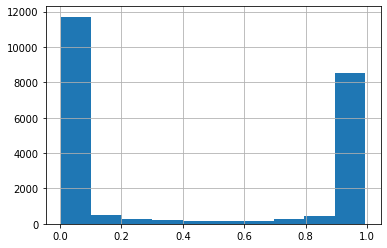

In [16]:
df['p'].hist();